<a href="https://colab.research.google.com/github/FelipeSotoG/U-Net-ResNetBlocks/blob/main/Attention_Resnet_SDP_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Descarga datos
Los datos se encuentran en el drive, por lo que usara gdown para sacarlos directamente y no tener que hacer la coneccion, ya que estamos descargando un zip.

In [1]:
!gdown https://drive.google.com/uc?id=1f3hc0IdnyN60NjGoPO9Za9Vnmj9pk3zt

Downloading...
From: https://drive.google.com/uc?id=1f3hc0IdnyN60NjGoPO9Za9Vnmj9pk3zt
To: /content/input.zip
100% 597M/597M [00:05<00:00, 105MB/s]


In [2]:
!unzip -q input.zip

In [3]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 1

In [4]:
import nibabel as nib
import os
import numpy as np
from nibabel.testing import data_path
import matplotlib.pyplot as plt
import cv2
import torch

In [5]:
import imageio as iio
import glob
from skimage.transform import resize
src="/content/input/train"
imag="/images/"
X=np.zeros((len(glob.glob(src+imag+"*.png")),IMG_WIDTH,IMG_HEIGHT,1))
for i,x in enumerate(sorted(glob.glob(src+imag+"*.png"))):
  X[i]=resize(iio.imread(x),(IMG_WIDTH,IMG_HEIGHT,1),mode="constant",preserve_range=True)
mas="/masks/"
Y=np.zeros((len(glob.glob(src+mas+"*.png")),IMG_WIDTH,IMG_HEIGHT,1))
for i,x in enumerate(sorted(glob.glob(src+mas+"*.png"))):
  Y[i]=resize(iio.imread(x),(IMG_WIDTH,IMG_HEIGHT,1),mode="constant",preserve_range=True)/255

##Borrar directorio /input en caso de error

In [ ]:
!rm -r /content/input

##Train Test Split

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.3, random_state=2)

##Resnet

In [7]:
from keras.layers import Layer
import keras.backend as K
import torch.nn as nn

In [8]:
def DiceMetric(y_true, y_pred):
  smooth=1e-6 
  gama=2
  y_true, y_pred = tf.cast(
      y_true, dtype=tf.float32), tf.cast(y_pred, tf.float32)
  nominator = 2 * \
      tf.reduce_sum(tf.multiply(y_pred, y_true)) + smooth
  denominator = tf.reduce_sum(
      y_pred ** gama) + tf.reduce_sum(y_true ** gama) + smooth
  result = tf.divide(nominator, denominator)
  return result
def DiceLoss(y_true, y_pred):
      result= 1- DiceMetric(y_true, y_pred)
      return result

In [9]:
def conv_block(X,f,d=0.1,group=1):
  c = tf.keras.layers.Conv2D(f[0], (2, 2), activation='relu', kernel_initializer='he_normal', padding='same',groups=group)(X)
  c = tf.keras.layers.BatchNormalization(axis=3)(c)
  c = tf.keras.layers.Dropout(d)(c)
  c = tf.keras.layers.Conv2D(f[1], (2, 2), kernel_initializer='he_normal', padding='same', groups=group)(c)
  c = tf.keras.layers.BatchNormalization(axis=3)(c)
  s = tf.keras.layers.Conv2D(f[1], (2, 2), kernel_initializer='he_normal', padding='same')(X)
  s = tf.keras.layers.BatchNormalization(axis=3)(s)
  c = tf.keras.layers.Add()([c,s])
  c = tf.keras.layers.ReLU()(c)
  return c,s

Intentos fallidos de attention

El problema es que hacerles muchas capas de neuronas, o hacerles muchos calculos de atencion, hace que se demore mas y se pierde precicion.

In [52]:
def attentionblock(Q,V):
  v=tf.keras.layers.Dense(Q.shape[-1])(Q)
  k=tf.keras.layers.Dense(Q.shape[-1])(Q)
  q=tf.keras.layers.Dense(Q.shape[-1])(Q) 
  Q=tf.keras.layers.Attention()([q,v,k])
  v=tf.keras.layers.Dense(V.shape[-1])(V)
  k=tf.keras.layers.Dense(V.shape[-1])(V)
  q=tf.keras.layers.Dense(V.shape[-1])(V) 
  V=tf.keras.layers.Attention()([q,v,k])
  V = tf.keras.layers.Conv2DTranspose(Q.shape[-1], (2, 2), strides=(2, 2), padding='same')(V)
  v=tf.keras.layers.Dense(Q.shape[-1])(V)
  k=tf.keras.layers.Dense(Q.shape[-1])(Q)
  q=tf.keras.layers.Dense(Q.shape[-1])(Q) 
  out=tf.keras.layers.Attention()([q,v,k])
  return out


In [67]:
def attentionblock(Q,V): 
  Q=tf.keras.layers.Attention()([Q,Q,Q])
  V=tf.keras.layers.Attention()([V,V,V])
  V = tf.keras.layers.Conv2DTranspose(Q.shape[-1], (2, 2), strides=(2, 2), padding='same')(V) 
  out=tf.keras.layers.Attention()([Q,V,V])
  return out

Bloque de atencion que funciono mejor

In [72]:
def attentionblock(Q,V): 
  V = tf.keras.layers.Conv2DTranspose(Q.shape[-1], (2, 2), strides=(2, 2), padding='same')(V) 
  out=tf.keras.layers.Attention()([Q,V,V])
  return out

In [73]:
import tensorflow as tf

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 1
nheads=16

#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)
#s= inputs
#Contraction path
c1,z1 = conv_block(s,[16,16])
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)


c2,z2 = conv_block(p1,[32,32])
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3,z3 = conv_block(p2,[64,64],0.2)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4,z4 = conv_block(p3,[128,128],0.2)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5,z5 = conv_block(p4,[256,256],0.3)

#Expansive path 
m1=attentionblock(z4,z5)
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, m1])
c6,z6 = conv_block(u6,[128,128],0.2)

m2=attentionblock(z3,z6)
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, m2])
c7,z7 = conv_block(u7,[64,64],0.2)

m3=attentionblock(z2,z7)
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, m3])
c8,z8 = conv_block(u8,[32,32])

m4=attentionblock(z1,z8) 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, m4], axis=3)
c9,_ = conv_block(u9,[16,16])
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',DiceMetric])
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 lambda_26 (Lambda)             (None, 128, 128, 1)  0           ['input_27[0][0]']               
                                                                                                  
 conv2d_507 (Conv2D)            (None, 128, 128, 16  80          ['lambda_26[0][0]']              
                                )                                                                 
                                                                                            

##Model Fit

In [74]:
model.fit(X_train,Y_train,batch_size=20,epochs=25,validation_split=0.2)

Epoch 1/25
99/99 [==============================] - 12s 86ms/step - loss: 0.2117 - accuracy: 0.9600 - DiceMetric: 0.1085 - val_loss: 0.1421 - val_accuracy: 0.9855 - val_DiceMetric: 0.0977
Epoch 2/25
99/99 [==============================] - 8s 78ms/step - loss: 0.0697 - accuracy: 0.9871 - DiceMetric: 0.2143 - val_loss: 0.0735 - val_accuracy: 0.9855 - val_DiceMetric: 0.0782
Epoch 3/25
99/99 [==============================] - 8s 78ms/step - loss: 0.0411 - accuracy: 0.9878 - DiceMetric: 0.4494 - val_loss: 0.0578 - val_accuracy: 0.9855 - val_DiceMetric: 0.0462
Epoch 4/25
99/99 [==============================] - 8s 78ms/step - loss: 0.0283 - accuracy: 0.9882 - DiceMetric: 0.6081 - val_loss: 0.0486 - val_accuracy: 0.9855 - val_DiceMetric: 0.0638
Epoch 5/25
99/99 [==============================] - 8s 78ms/step - loss: 0.0216 - accuracy: 0.9884 - DiceMetric: 0.7063 - val_loss: 0.0380 - val_accuracy: 0.9857 - val_DiceMetric: 0.2433
Epoch 6/25
99/99 [==============================] - 8s 78ms/step

In [77]:
scores= model.evaluate(X_test, Y_test, verbose=0)
print(f'Score for fold {0}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}% {model.metrics_names[2]} of {scores[2]*100}%')
print(model.metrics_names)

Score for fold 0: loss of 0.007760524749755859; accuracy of 98.95282983779907% DiceMetric of 89.5677924156189%
['loss', 'accuracy', 'DiceMetric']


In [ ]:
print(model.metrics_names)

##Testing

In [75]:
Ypred=model.predict(X_test)

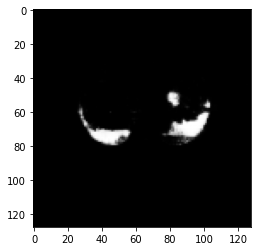

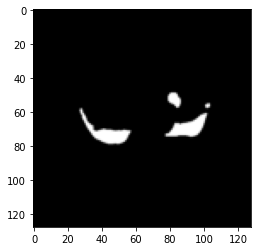

In [76]:
plt.imshow(np.reshape(Ypred[160],(128,128)), cmap=plt.cm.gray)
plt.show()
plt.imshow(np.reshape(Y_test[160],(128,128)), cmap=plt.cm.gray)
plt.show()

In [78]:
def dice(true_mask, pred_mask):
    """
        Computes the Dice coefficient.
        Args:
            true_mask : Array of arbitrary shape.
            pred_mask : Array with the same shape than true_mask.  
        
        Returns:
            A scalar representing the Dice coefficient between the two segmentations. 
        
    """
    non_seg_score=1.0
    if type(pred_mask) != np.ndarray:
      t = torch.Tensor([0.5])
      pred_mask=(pred_mask > t)
    else:
      pred_mask[pred_mask>=0.5]=1
      pred_mask[pred_mask<0.5]=0

    # If both segmentations are all zero, the dice will be 1. (Developer decision)
    im_sum = true_mask.sum() + pred_mask.sum()
    if im_sum == 0:
        return non_seg_score

    # Compute Dice coefficient
    intersection = np.logical_and(true_mask, pred_mask)
    return 2. * intersection.sum() / im_sum

In [79]:
diceaux=dice(Y_test[160],Ypred[160])
diceaux

0.9644930416996391

## Model Fit Kfold

In [81]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import absolute
from numpy import sqrt
import pandas as pd

In [82]:
cv = KFold(n_splits=5, random_state=1, shuffle=True)

25 epochs

In [83]:
VALIDATION_ACCURACY = []
VALIDAITON_LOSS = []
nfold=1
for train_index, val_index in cv.split(X,Y):
  model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',DiceMetric])

  X_fold=X[train_index,:,:]
  Y_fold=Y[train_index,:,:]
  
  model.fit(X_fold,Y_fold,batch_size=16,epochs=25,validation_split=0.2,verbose=0)

  Xtest_fold=X[val_index,:,:]
  Ytest_fold=Y[val_index,:,:]
  scores= model.evaluate(Xtest_fold, Ytest_fold, verbose=0)
  print(f'Score for fold {nfold}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}% {model.metrics_names[2]} of {scores[2]*100}%')
  nfold+=1

Score for fold 1: loss of 0.015375291928648949; accuracy of 98.92076849937439% DiceMetric of 85.06117463111877%
Score for fold 2: loss of 0.0173810888081789; accuracy of 98.82116317749023% DiceMetric of 86.53574585914612%
Score for fold 3: loss of 0.029940396547317505; accuracy of 98.86179566383362% DiceMetric of 80.37702441215515%
Score for fold 4: loss of 0.021816927939653397; accuracy of 98.8555908203125% DiceMetric of 80.62856793403625%
Score for fold 5: loss of 0.02643907628953457; accuracy of 98.90596866607666% DiceMetric of 81.0717225074768%


50 epochs

In [84]:
VALIDATION_ACCURACY = []
VALIDAITON_LOSS = []
nfold=1
for train_index, val_index in cv.split(X,Y):
  model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',DiceMetric])

  X_fold=X[train_index,:,:]
  Y_fold=Y[train_index,:,:]
  
  model.fit(X_fold,Y_fold,batch_size=16,epochs=50,validation_split=0.2,verbose=0)

  Xtest_fold=X[val_index,:,:]
  Ytest_fold=Y[val_index,:,:]
  scores= model.evaluate(Xtest_fold, Ytest_fold, verbose=0)
  print(f'Score for fold {nfold}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}% {model.metrics_names[2]} of {scores[2]*100}%')
  nfold+=1

Score for fold 1: loss of 0.026712991297245026; accuracy of 98.92278909683228% DiceMetric of 85.75470447540283%
Score for fold 2: loss of 0.03414676710963249; accuracy of 98.79527688026428% DiceMetric of 84.62190628051758%
Score for fold 3: loss of 0.030036412179470062; accuracy of 98.86870980262756% DiceMetric of 83.15788507461548%
Score for fold 4: loss of 0.030506402254104614; accuracy of 98.86631369590759% DiceMetric of 85.55557131767273%
Score for fold 5: loss of 0.030434055253863335; accuracy of 98.91023635864258% DiceMetric of 82.77513980865479%
